In [14]:
import pandas as pd
import pickle
import mlflow

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [16]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso

from sklearn.metrics import mean_squared_error


In [17]:


mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc_taxi_experiment")

<Experiment: artifact_location='/workspaces/mlops/01-intro/mlruns/1', creation_time=1755256866442, experiment_id='1', last_update_time=1755256866442, lifecycle_stage='active', name='nyc_taxi_experiment', tags={}>

In [18]:
def read_dataFrame(filename):
    data = pd.read_parquet(filename)
    #df = data.lpep_dropoff_datetime - data.lpep_dropoff_datetime
    
    data["duration"] = data.lpep_dropoff_datetime - data.lpep_pickup_datetime
    data.duration = data.duration.apply(lambda td: td.total_seconds()/60)
    
    data = data[(data.duration >= 1) & (data.duration <= 60)]
    
    categorical = ['PULocationID', 'DOLocationID']
    data[categorical] = data[categorical].astype(str)
    
    return data


In [19]:
df_train = read_dataFrame("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.parquet")
df_val = read_dataFrame("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-02.parquet")


In [20]:
len(df_train), len(df_val)

(54373, 51497)

In [21]:
#data = data[data.trip_type == 2]

In [22]:
((df_train.duration >= 1) & (df_train.duration <= 60)).mean()

1.0

In [23]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [24]:
categorical = ['PU_DO'] #['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)


In [25]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [26]:

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

5.982610254412603

In [27]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)
    

In [31]:
ls

duration-prediction.ipynb  mlflow.db  mlruns/  models/


In [33]:
with mlflow.start_run():
    
    mlflow.set_tag("developer", "Jayanth")
    mlflow.log_param("train-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.parquet")
    mlflow.log_param("valid-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-02.parquet")
    
    alpha = 0.0001
    mlflow.log_param("alpha", alpha)
    
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    
    mlflow.log_metric("rmse", rmse)
    
    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


OptionError: "No such keys(s): 'mode.use_inf_as_null'"

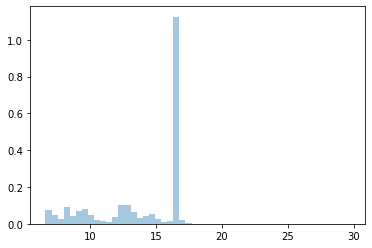

In [30]:
sns.distplot(y_pred, label='Prediction')
sns.distplot(y_train, label='Actual')

plt.legend()

In [38]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [42]:
#def objective(params):
with mlflow.start_run():

    best_params = {
        'learning_rate': 0.09,
        'max_depth': 30,
        'min_child_weight': 1.060,
        'objective': 'reg:linear',
        'reg_alpha': 0.018,
        'reg_lambda': 0.011,
        'seed': 42
    }

    mlflow.log_params(best_params)


    mlflow.set_tag("model", "xgboost")
    #mlflow.log_params(params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    
    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")


#return {'loss': rmse, 'status': STATUS_OK}

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:55:40] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:8.58472
[1]	validation-rmse:8.12303
[2]	validation-rmse:7.71977
[3]	validation-rmse:7.36880
[4]	validation-rmse:7.06321
[5]	validation-rmse:6.80126
[6]	validation-rmse:6.57273
[7]	validation-rmse:6.37762
[8]	validation-rmse:6.21141
[9]	validation-rmse:6.07122
[10]	validation-rmse:5.94886
[11]	validation-rmse:5.84671
[12]	validation-rmse:5.75886
[13]	validation-rmse:5.68406
[14]	validation-rmse:5.62205
[15]	validation-rmse:5.56547
[16]	validation-rmse:5.51986
[17]	validation-rmse:5.47952
[18]	validation-rmse:5.44537
[19]	validation-rmse:5.41801
[20]	validation-rmse:5.39088
[21]	validation-rmse:5.36801
[22]	validation-rmse:5.34852
[23]	validation-rmse:5.33072
[24]	validation-rmse:5.31828
[25]	validation-rmse:5.30361
[26]	validation-rmse:5.29280
[27]	validation-rmse:5.28136
[28]	validation-rmse:5.27202
[29]	validation-rmse:5.26401
[30]	validation-rmse:5.25646
[31]	validation-rmse:5.24947
[32]	validation-rmse:5.24351
[33]	validation-rmse:5.23862
[34]	validation-rmse:5.2

[277]	validation-rmse:5.15591
[278]	validation-rmse:5.15557
[279]	validation-rmse:5.15483
[280]	validation-rmse:5.15475
[281]	validation-rmse:5.15422
[282]	validation-rmse:5.15418
[283]	validation-rmse:5.15418
[284]	validation-rmse:5.15379
[285]	validation-rmse:5.15371
[286]	validation-rmse:5.15382
[287]	validation-rmse:5.15350
[288]	validation-rmse:5.15348
[289]	validation-rmse:5.15354
[290]	validation-rmse:5.15344
[291]	validation-rmse:5.15350
[292]	validation-rmse:5.15339
[293]	validation-rmse:5.15345
[294]	validation-rmse:5.15336
[295]	validation-rmse:5.15335
[296]	validation-rmse:5.15327
[297]	validation-rmse:5.15331
[298]	validation-rmse:5.15321
[299]	validation-rmse:5.15315
[300]	validation-rmse:5.15308
[301]	validation-rmse:5.15325
[302]	validation-rmse:5.15345
[303]	validation-rmse:5.15341
[304]	validation-rmse:5.15281
[305]	validation-rmse:5.15242
[306]	validation-rmse:5.15238
[307]	validation-rmse:5.15131
[308]	validation-rmse:5.15119
[309]	validation-rmse:5.15121
[310]	vali

[551]	validation-rmse:5.14220
[552]	validation-rmse:5.14216
[553]	validation-rmse:5.14218
[554]	validation-rmse:5.14230
[555]	validation-rmse:5.14222
[556]	validation-rmse:5.14216
[557]	validation-rmse:5.14214
[558]	validation-rmse:5.14216
[559]	validation-rmse:5.14220
[560]	validation-rmse:5.14222
[561]	validation-rmse:5.14227


2025/08/15 16:56:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:56:34] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/08/15 16:56:36 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp1ggf9hg3/model, flavor: xgboost). Fall back to return ['xgboost==2.1.4']. Set logging level to DEBUG to see the full traceback. 
2025/08/15 16:56:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [ ]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)